In [1]:
# Import universal packages:
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import time
from matplotlib import animation
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
import time
import matplotlib.animation as animation


# The model

In [2]:
def update(last_x, last_Tns, last_counter, step, N_steps_day, DIU, cp_cooling):

    """Makes one step in the cellular automaton.
    Args:
        last_x (np.array): current state of the rain field (1: rain, 0: no rain)
        last_Tns (np.array): current probability matrix (physically near surface temperature T_ns, in units: 20 K)
        last_counter (np.array): keeping track of lifetimes of rain events 
        step : what step of the cellular automaton are we updating
        N_steps_day : how many steps in a day
        DIU : True, if oscillating Ts, False, if constant Ts
    Returns:
        x (np.array): updated state of the rain field
        Tns (np.array): updated state of the near surface temperature
    """
    parameters(N_steps_day)
    
    new_counter            = last_counter
    new_counter            = np.where(np.logical_and(last_x==1,last_counter==lifetime_rain),-1,new_counter)
    deactivate_CP_regions  = np.where(new_counter<0,-cp_cooling,0)    
    new_counter            = np.where(np.logical_and(last_x==1,last_counter>=0,last_counter<lifetime_rain),\
                               new_counter+1,new_counter)
    
    # applying the surface heat flux
    new_Tns = last_Tns + D_T*(Ts(step, N_steps_day,DIU)-last_Tns) + deactivate_CP_regions

    new_Tns = convolve2d(new_Tns, kernel_diff, 'same', boundary = 'wrap')

    
    eightneighboravg           = convolve2d(last_x, kernel, 'same', boundary = 'wrap')
    boost_Tns_inactive_regions = np.where(last_x==0,eightneighboravg,0)
    prolong_active_regions     = np.where(np.logical_and(new_counter>0, new_counter<lifetime_rain),1,0)
    


    
    return new_Tns, prolong_active_regions, boost_Tns_inactive_regions, new_counter

In [314]:
def Ts(step, N_steps_day, DIU):
    parameters(N_steps_day)
    if (DIU==True):
        Ts = avg_Ts - amp_Ts*np.cos(2*np.pi*np.mod(step,N_steps_day)/N_steps_day)
    else:
        Ts = avg_Ts
    return Ts


def modellino(N_steps_day, tot_steps, DIU, persistence, branching, Tns_branch):
    parameters(N_steps_day)
    """ Game of Cloud, initiated from the night
    Args:
        pixels (int): number of cells in the row
        N_steps_day (int): number of timesteps in a day
        tot_steps (int): total number of steps to evolve the automaton
        lifetime_rain (int): number of steps that an active pixel persists
    Returns:    
        x: states of the automaton
        P: probability field of the automaton
    """
    
    parameters(N_steps_day) #calling all parameters
    
    x = np.zeros((tot_steps, pixels,pixels))
    Tns = np.zeros((tot_steps, pixels,pixels))
    Tns[0,:,:] = np.ones((pixels,pixels)) * (avg_Ts - 1) +   .1 * (np.random.random((pixels,pixels)) - .5)
    
    if branching==True:
        Tns[0,:,:] = Tns_branch
           
    counter = np.zeros((tot_steps, pixels,pixels))
    trop_temp_saved=np.zeros(tot_steps)
    trop_temp_saved[0] = avg_Ts
    
    t00 = time.time()
    # with global constraint:
    for step in range(0,tot_steps-1):
        time0 = time.time()
        (Tns[step + 1, :], prolong_active_regions, boost_Tns_inactive_regions, counter[step+1,:]) = update(
            x[step, :], Tns[step, :], counter[step,:], step, N_steps_day, DIU, cp_cooling) 

        trop_temp = trop_temp_saved[step]
        
        

        # persistence
        if persistence=='yes':
            # just computing the anomalies
            anomalies        = Tns[step + 1,:] - np.mean(Tns[step + 1,:])
            # applying a "rich-gets-richer" feedback with a "carrying capacity" on both ends
            boosted_Tns      = Tns[step + 1,:] + (1. + anomalies) * (1. - anomalies) * anomalies * persistence_boost
            # updating Tns accordingly
            Tns[step + 1, :] = boosted_Tns
            
        
        Tns[step + 1, :] = Tns[step + 1, :] + boost_Tns_inactive_regions * np.mean(Tns[step + 1, :]) * cp_cooling * interaction
        #Tns[step + 1, :] = Tns[step + 1, :] + boost_Tns_inactive_regions * .6 * cp_cooling * interaction
        #booster = Tns[step + 1, :] + boost_Tns_inactive_regions * .3 * cp_cooling * interaction
        booster = Tns[step + 1, :]
            
 
        Tns_unstable = np.where(np.logical_and((booster - trop_temp)>0, prolong_active_regions==0), \
                                booster, 0)

        
        x_pot  = np.zeros((pixels,pixels))
        x_fire = np.zeros((pixels,pixels))
        x_pot  = x_pot.flatten()

        sumTns = np.zeros(len(x_pot))

        if np.sum(Tns_unstable)>0:
            sumTns = np.cumsum(Tns_unstable/np.sum(Tns_unstable))

        # loop to select among positively buoyant pixels:
        # let a pixel fire, update free_trop_temp, continue until there are no more pixels

            for fire in range(len(sumTns)):
                random_number = np.random.rand()
                selection_index = np.where(sumTns>=random_number)[0][0] 
                if (trop_temp < Tns_unstable.flatten()[selection_index] and x_pot[selection_index] == 0):
                    x_pot[selection_index] = 1
                    trop_temp = trop_temp + event_heating 

        x_fire = x_pot.reshape((pixels,pixels))

        # applying radiative cooling of the free troposphere
        trop_temp = trop_temp - trop_cooling 
        
        # updating saved information on the free troposphere
        trop_temp_saved[step+1]=trop_temp
        x[step+1, :] = prolong_active_regions + x_fire



    return x,Tns,counter,trop_temp_saved

def calc_corr(x, ndays, N_steps_day):
    days=ndays
    steps = N_steps_day
    x_new = x.reshape((days,steps,pixels,pixels))
    x_mean = x_new.mean(1)
    corr=np.zeros(days)
    for it in range(1,days):
        # applying a gaussian filter before computing the day-to-day correlation function
        x_mean_f0 = gaussian_filter(x_mean[it],   sigma=1)
        x_mean_f1 = gaussian_filter(x_mean[it-1], sigma=1)
        # corr[it]= np.corrcoef(x_mean[it].flatten(),x_mean[it-1].flatten())[0, 1]
        corr[it]= np.corrcoef(x_mean_f0.flatten(),x_mean_f1.flatten())[0, 1]
    return corr

# The parameters

In [448]:
def parameters(N_steps_day):
    # parameters:
    global D_T, D_diff, cp_cooling, avg_Ts, amp_Ts, lifetime_rain, interaction, persistence_boost
    global pixels, event_heating, trop_cooling
    global delta_T, delta_x, alpha
    global kernel_diff, kernel
    global nsteps_day
    persistence_boost = 0.06 # scale the rich-gets-richer anomaly boost
    D_T = 0.05 # 0.05 works # unit: unitless, coefficient that determines how the T_ns is modulated by the T_s #0.05
    D_diff = 1e2 # 4.2  # 4.2 works, was 0.6 # unit: m**2/s, coefficient that determines how quickly the field is 'diffused'  #0.8 # 0.4 #0.6
    cp_cooling = 2/20
    avg_Ts = 0.5 # unit: 20 K 
    amp_Ts = 0.5 # unit: 20 K
    lifetime_rain = 2 # unit: time steps that rain lasts and can interact
    interaction = 0.7 #scale the interaction coefficient 
    pixels = 50 # number of pixels on one side of the domain, assuming one is 10x10 km**2 (total domain = pixels x pixels)
    event_heating = (4/20)/pixels**2 # unit: 20 K, tropospheric heating due to 1 single convective event
    trop_cooling = (3/20)/N_steps_day # unit: 20 K, free tropospheric cooling in one time step
    delta_T = (24/N_steps_day*60)*60 # unit: s, minutes in a time step * seconds in a minute
    delta_x = 10*1e3 # units: m, theoretical size of grid box in m(10 km)
    alpha = D_diff*delta_T/(delta_x**2)   # unit: unitless, m**2/s  *   s/m**2
    
    kernel_diff = alpha * np.array([[0, 1, 0], 
                                    [1, 0, 1],
                                    [0, 1, 0]]) + (1-4*alpha)* np.array([[0, 0, 0], 
                                                                         [0, 1, 0],
                                                                         [0, 0, 0]])
    kernel      = (1/8) * np.array([[1, 1, 1],
                                    [1, 0, 1],
                                    [1, 1, 1]])

# Run multiple days of DIU and plot

In [449]:
nsteps_day=48

In [450]:
ndays = 42

x, Tns, counter,trop_temp_saved = modellino(N_steps_day=nsteps_day, tot_steps=nsteps_day*ndays, DIU=True, 
                                            persistence='yes', branching=False, Tns_branch=False)


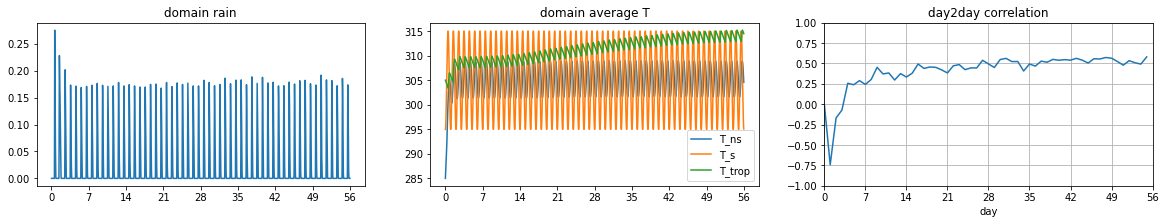

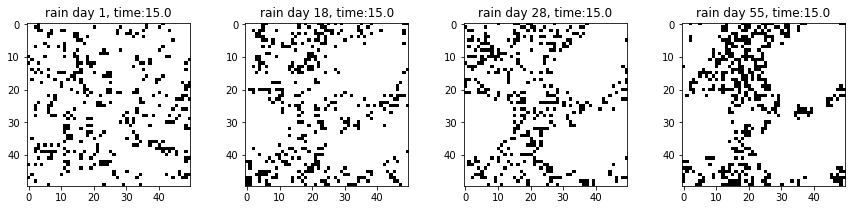

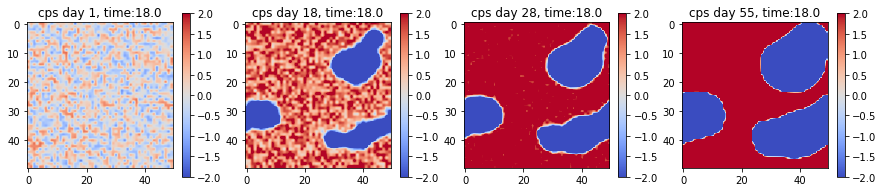

avg activity 0.024767708333333336


In [553]:
%matplotlib inline

cps = Tns[:] - np.mean(Tns,axis=(1,2))[:,None,None]

fig = plt.figure(figsize=(20,3))
ax1 = plt.subplot(131)

ax1.set_title('domain rain')
ax1.plot(np.arange(0,np.size(np.mean(x, axis=(1,2)))), np.mean(x, axis=(1,2)))
xaxis=np.arange(0,len(x)+1,nsteps_day)
ax1.set_xticks(np.arange(0,(ndays+1)*nsteps_day,7*nsteps_day))
ax1.set_xticklabels(np.arange(0,ndays+1,7))
               
ax2 = plt.subplot(132)
ax2.set_title('domain average T')
ax2.plot(np.arange(0,np.size(np.mean(Tns, axis=(1,2)))), 295+20*np.mean(Tns, axis=(1,2)), label='T_ns')
ax2.plot(np.arange(0,np.size(np.mean(Tns, axis=(1,2)))), 295+20*Ts(np.arange(0,np.size(np.mean(Tns, axis=(1,2)))),nsteps_day,True), label='T_s')
ax2.plot(295+20*trop_temp_saved, label='T_trop')
ax2.legend()
ax2.set_xticks(np.arange(0,(ndays+1)*nsteps_day,7*nsteps_day))
ax2.set_xticklabels(np.arange(0,ndays+1,7))


ax3 = plt.subplot(133)
ax3.set_title('day2day correlation')
ax3.plot(np.arange(0,ndays),calc_corr(x, ndays, N_steps_day = nsteps_day))
ax3.set_ylim(-1,1)
ax3.set_xlim(0,ndays)
ax3.set_xlabel('day')

ax3.set_xticks(np.arange(0,ndays+1,7))
ax3.set_xticklabels(np.arange(0,ndays+1,7))
ax3.grid()

plt.show()


fig = plt.figure(figsize=(15,3))

d4 = 1
d3 = int(ndays/3)
d2 = int(ndays/2)
d1 = ndays-1

plotstep = 30
day_minus4=(x[nsteps_day*d4 + plotstep])
day_minus3=(x[nsteps_day*d3 + plotstep])
day_minus2=(x[nsteps_day*d2 + plotstep])
day_last  =(x[nsteps_day*d1 + plotstep])
ax1 = plt.subplot(141)
ax1.imshow(day_minus4, cmap='Greys',vmin=0, vmax=0.1)
ax1.set_title('rain day ' + str(d4) + ', time:' + str(24*plotstep/48))
ax2 = plt.subplot(142)
ax2.imshow(day_minus3, cmap='Greys',vmin=0, vmax=0.1)
ax2.set_title('rain day ' + str(d3)+ ', time:' + str(24*plotstep/48))
ax3 = plt.subplot(143)
ax3.imshow(day_minus2, cmap='Greys',vmin=0, vmax=0.1)
ax3.set_title('rain day ' + str(d2)+ ', time:' + str(24*plotstep/48))
ax4 = plt.subplot(144)
ax4.imshow(day_last, cmap='Greys',vmin=0, vmax=0.1)
ax4.set_title('rain day ' + str(d1)+ ', time:' + str(24*plotstep/48))

plotstep = 36
fig = plt.figure(figsize=(15,3))
vmin=-2
vmax=2
day_minus4=(20*cps[nsteps_day*d4 + plotstep,:,:])
day_minus3=(20*cps[nsteps_day*d3 + plotstep,:,:])
day_minus2=(20*cps[nsteps_day*d2 + plotstep,:,:])
day_last  =(20*cps[nsteps_day*d1 + plotstep,:,:])
ax1 = plt.subplot(141)
im1 = ax1.imshow(day_minus4, cmap='coolwarm',vmin=vmin, vmax=vmax)
ax1.set_title('cps day ' + str(d4) + ', time:' + str(24*plotstep/48))
ax2 = plt.subplot(142)
im2 = ax2.imshow(day_minus3, cmap='coolwarm',vmin=vmin, vmax=vmax)
ax2.set_title('cps day ' + str(d3) + ', time:' + str(24*plotstep/48))
ax3 = plt.subplot(143)
im3 = ax3.imshow(day_minus2, cmap='coolwarm',vmin=vmin, vmax=vmax)
ax3.set_title('cps day ' + str(d2) + ', time:' + str(24*plotstep/48))
ax4 = plt.subplot(144)
im4 = ax4.imshow(day_last, cmap='coolwarm',vmin=vmin, vmax=vmax)
ax4.set_title('cps day ' + str(d1)+ ', time:' + str(24*plotstep/48))

fig.colorbar(im1, ax=ax1, orientation='vertical')
fig.colorbar(im2, ax=ax2, orientation='vertical')
fig.colorbar(im3, ax=ax3, orientation='vertical')
fig.colorbar(im4, ax=ax4, orientation='vertical')

plt.show()

print('avg activity', np.mean(np.mean(x, axis=(1,2))))


# Run OCEAN and plot


In [563]:
%matplotlib inline
ndays_ocean = 35

x_ocean, Tns_ocean, counter_ocean, trop_temp_saved_ocean = modellino(
    N_steps_day = nsteps_day, tot_steps = nsteps_day*ndays_ocean, DIU=False, 
    persistence='yes', branching=False, Tns_branch=False) 

# set branching=True and Tns_branch=Tns[-1] to branch from last step of DIU

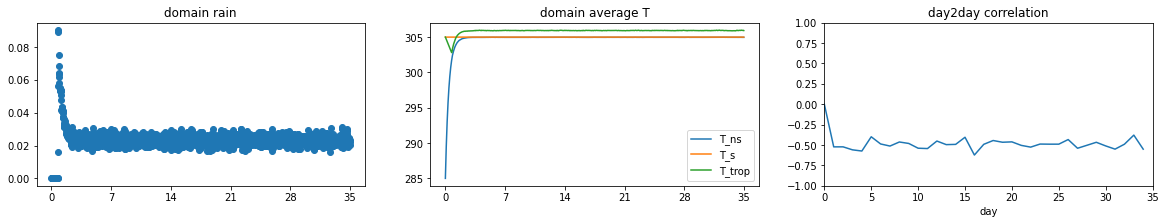

avg activity 0.023633571428571427


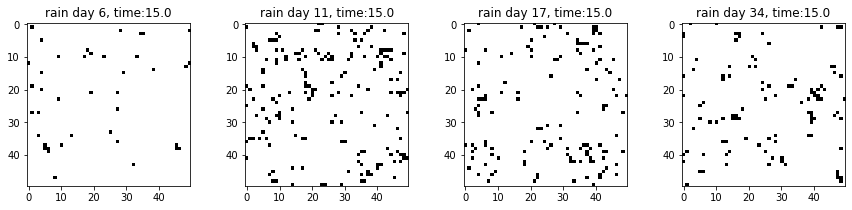

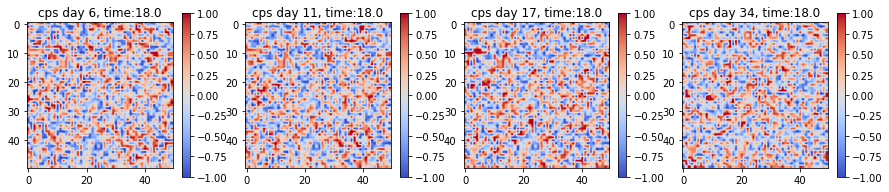

In [570]:
%matplotlib inline

cps_ocean = Tns_ocean[:] - np.mean(Tns_ocean,axis=(1,2))[:,None,None]

fig = plt.figure(figsize=(20,3))
ax1 = plt.subplot(131)

ax1.set_title('domain rain')
ax1.scatter(np.arange(0,np.size(np.mean(x_ocean, axis=(1,2)))), np.mean(x_ocean, axis=(1,2)))
xaxis=np.arange(0,len(x_ocean)+1,nsteps_day)
#ax1.set_xticks([])
ax1.set_xticks(np.arange(0,(ndays_ocean+1)*nsteps_day,7*nsteps_day))
ax1.set_xticklabels(np.arange(0,ndays_ocean+1,7))

ax2 = plt.subplot(132)
ax2.set_title('domain average T')
ax2.plot(np.arange(0,np.size(np.mean(Tns_ocean, axis=(1,2)))), 295+20*np.mean(Tns_ocean, axis=(1,2)), label='T_ns')
ax2.plot(np.arange(0,np.size(np.mean(Tns_ocean, axis=(1,2)))), 295+20*Ts(0,nsteps_day, False)*np.ones(np.size(np.mean(Tns_ocean, axis=(1,2)))), label='T_s')
ax2.plot(295+20*trop_temp_saved_ocean, label='T_trop')
ax2.legend()
ax2.set_xticks(np.arange(0,(ndays_ocean+1)*nsteps_day,7*nsteps_day))
ax2.set_xticklabels(np.arange(0,ndays_ocean+1,7))

ax3 = plt.subplot(133)
ax3.set_title('day2day correlation')
ax3.plot(np.arange(0,ndays_ocean),calc_corr(x_ocean, ndays_ocean, N_steps_day = nsteps_day))
ax3.set_ylim(-1,1)
ax3.set_xlim(0,ndays_ocean)
ax3.set_xlabel('day')
#ax3.grid()

plt.show()


#d4 = round(ndays_ocean/4-1)
#d3 = round(2*ndays_ocean/4-1)
#d2 = round(3*ndays_ocean/4-1)
#d1 = round(4*ndays_ocean/4-1)
d4 = 6
d3 = int(ndays_ocean/3)
d2 = int(ndays_ocean/2)
d1 = ndays_ocean-1


fig = plt.figure(figsize=(15,3))

#day_minus4=np.mean(x_ocean[-nsteps_day*d1:-nsteps_day*(d1-1),:,:], axis=(0))
#day_minus3=np.mean(x_ocean[-nsteps_day*d2:-nsteps_day*(d2-1),:,:], axis=(0))
#day_minus2=np.mean(x_ocean[-nsteps_day*d3:-nsteps_day*(d3-1),:,:], axis=(0))
#day_last  =np.mean(x_ocean[-nsteps_day*d4:-nsteps_day*(d4-1),:,:], axis=(0))
plotstep = 30
day_minus4=(x_ocean[d4 + plotstep])
day_minus3=(x_ocean[d3 + plotstep])
day_minus2=(x_ocean[d2 + plotstep])
day_last  =(x_ocean[d1 + plotstep])
ax1 = plt.subplot(141)
ax1.imshow(day_minus4, cmap='Greys',vmin=0, vmax=0.1)
ax1.set_title('rain day ' + str(d4)+ ', time:' + str(24*plotstep/48))
ax2 = plt.subplot(142)
ax2.imshow(day_minus3, cmap='Greys',vmin=0, vmax=0.1)
ax2.set_title('rain day ' + str(d3)+ ', time:' + str(24*plotstep/48))
ax3 = plt.subplot(143)
ax3.imshow(day_minus2, cmap='Greys',vmin=0, vmax=0.1)
ax3.set_title('rain day ' + str(d2)+ ', time:' + str(24*plotstep/48))
ax4 = plt.subplot(144)
ax4.imshow(day_last, cmap='Greys',vmin=0, vmax=0.1)
ax4.set_title('rain day ' + str(d1)+ ', time:' + str(24*plotstep/48))

fig = plt.figure(figsize=(15,3))
#day_minus4=np.mean(20*Tns_ocean[-nsteps_day*d1:-nsteps_day*(d1-1),:,:], axis=(0))
#day_minus3=np.mean(20*Tns_ocean[-nsteps_day*d2:-nsteps_day*(d2-1),:,:], axis=(0))
#day_minus2=np.mean(20*Tns_ocean[-nsteps_day*d3:-nsteps_day*(d3-1),:,:], axis=(0))
#day_last  =np.mean(20*Tns_ocean[-nsteps_day*d4:-nsteps_day*(d4-1),:,:], axis=(0))
plotstep= 36
day_minus4=(20*cps_ocean[d4 + plotstep,:,:])
day_minus3=(20*cps_ocean[d3 + plotstep,:,:])
day_minus2=(20*cps_ocean[d2 + plotstep,:,:])
day_last  =(20*cps_ocean[d1 + plotstep,:,:])


ax1 = plt.subplot(141)
im1 = ax1.imshow(day_minus4, cmap='coolwarm',vmin=-1, vmax=1)
ax1.set_title('cps day ' + str(d4) + ', time:' + str(24*plotstep/48))
ax2 = plt.subplot(142)
im2 = ax2.imshow(day_minus3, cmap='coolwarm',vmin=-1, vmax=1)
ax2.set_title('cps day ' + str(d3) + ', time:' + str(24*plotstep/48))
ax3 = plt.subplot(143)
im3 = ax3.imshow(day_minus2, cmap='coolwarm',vmin=-1, vmax=1)
ax3.set_title('cps day ' + str(d2) + ', time:' + str(24*plotstep/48))
ax4 = plt.subplot(144)
im4 = ax4.imshow(day_last, cmap='coolwarm',vmin=-1, vmax=1)
ax4.set_title('cps day ' + str(d1) + ', time:' + str(24*plotstep/48))

fig.colorbar(im1, ax=ax1, orientation='vertical')
fig.colorbar(im2, ax=ax2, orientation='vertical')
fig.colorbar(im3, ax=ax3, orientation='vertical')
fig.colorbar(im4, ax=ax4, orientation='vertical')

print('avg activity', np.mean(np.mean(x_ocean, axis=(1,2))))

# Run ensemble of DIU + OCEAN + OCEAN branches, and plot

In [561]:
# NOTE: takes a while to run
ensemble_runs = 3
days1 = 28
days2 = 28
ndays              = days1 + days2
ndays_ocean        = days1 + days2
ndays_oceanBRANCH  = days2
daybranch1         = 5
daybranch2          = 21

corr_DIU_ALL=np.zeros((ensemble_runs,ndays))
corr_OCEAN_ALL=np.zeros((ensemble_runs,ndays_ocean))
corr_OCEANBRANCH1_ALL=np.zeros((ensemble_runs,ndays_oceanBRANCH))
corr_OCEANBRANCH2_ALL=np.zeros((ensemble_runs,ndays_oceanBRANCH))
#var_DIU_ALL=np.zeros((ensemble_runs,ndays))
#var_OCEAN_ALL=np.zeros((ensemble_runs,ndays_ocean))
#var_OCEANBRANCH1_ALL=np.zeros((ensemble_runs,ndays_oceanBRANCH))
#var_OCEANBRANCH2_ALL=np.zeros((ensemble_runs,ndays_oceanBRANCH))
var_DIU_ALL=np.zeros((ensemble_runs,ndays*nsteps_day))
var_OCEAN_ALL=np.zeros((ensemble_runs,ndays_ocean*nsteps_day))
var_OCEANBRANCH1_ALL=np.zeros((ensemble_runs,ndays_oceanBRANCH*nsteps_day))
var_OCEANBRANCH2_ALL=np.zeros((ensemble_runs,ndays_oceanBRANCH*nsteps_day))


for run in range(0,ensemble_runs):
    
    
    x, Tns, counter,trop_temp_saved = modellino(
        N_steps_day=nsteps_day, tot_steps=nsteps_day*ndays, DIU=True, 
        persistence='yes', branching=False, Tns_branch=False)
    
    corr_DIU_ALL[run] = calc_corr(x, ndays, N_steps_day=nsteps_day)
    #var_DIU_ALL[run] = [np.var(np.mean(Tns[-48*(n+1):-48*(n),:,:], axis=(0))) for n in list(range(ndays))]
    var_DIU_ALL[run] = np.var(Tns,axis=(1,2))
    
    x_oceanBRANCH1, Tns_oceanBRANCH1, counter_oceanBRANCH1, trop_temp_saved_oceanBRANCH1 = modellino(
        N_steps_day=nsteps_day, tot_steps=nsteps_day*ndays_oceanBRANCH, DIU=False, 
        persistence='yes', branching=True, Tns_branch=Tns[daybranch1*nsteps_day])

    
    corr_OCEANBRANCH1_ALL[run] = calc_corr(x_oceanBRANCH1, ndays_oceanBRANCH, N_steps_day=nsteps_day)
    #var_OCEANBRANCH1_ALL[run]= [np.var(np.mean(Tns_oceanBRANCH1[-48*(n+1):-48*(n),:,:], axis=(0))) for n in list(range(ndays_oceanBRANCH))]
    var_OCEANBRANCH1_ALL[run] = np.var(Tns_oceanBRANCH1,axis=(1,2))
   
    
    
    x_oceanBRANCH2, Tns_oceanBRANCH2, counter_oceanBRANCH2, trop_temp_saved_oceanBRANCH2 = modellino(
        N_steps_day=nsteps_day, tot_steps=nsteps_day*ndays_oceanBRANCH, DIU=False, 
        persistence='yes', branching=True, Tns_branch=Tns[daybranch2*nsteps_day])

    
    corr_OCEANBRANCH2_ALL[run] = calc_corr(x_oceanBRANCH2, ndays_oceanBRANCH, N_steps_day=nsteps_day)
    #var_OCEANBRANCH2_ALL[run]= [np.var(np.mean(Tns_oceanBRANCH2[-48*(n+1):-48*(n),:,:], axis=(0))) for n in list(range(ndays_oceanBRANCH))]
    var_OCEANBRANCH2_ALL[run] = np.var(Tns_oceanBRANCH2,axis=(1,2))
    
    x_ocean, Tns_ocean, counter_ocean, trop_temp_saved_ocean = modellino(
        N_steps_day=nsteps_day, tot_steps=nsteps_day*ndays_ocean, DIU=False, 
        persistence='yes', branching=False, Tns_branch=False)
    
    corr_OCEAN_ALL[run] = calc_corr(x_ocean, ndays_ocean, N_steps_day=nsteps_day)
    #var_OCEAN_ALL[run]=[np.var(np.mean(Tns_ocean[-48*(n+1):-48*(n),:,:], axis=(0))) for n in list(range(ndays_ocean))]
    var_OCEAN_ALL[run] = np.var(Tns_ocean,axis=(1,2))
    
print('finished')

KeyboardInterrupt: 

In [541]:
def plot_branches_all_spread(diu, diu_std, ocean, ocean_std, branch1, branch1_std, branch2, branch2_std, name, spread='no',log='no', daybranch1=daybranch1, daybranch2=daybranch2):
    var = diu
    std = diu_std
    var_ocean = ocean
    std_ocean = ocean_std
    daybranch1= daybranch1
    daybranch2= daybranch2
    var_ocA1 = branch1
    std_ocA1 = branch1_std
    var_ocA2 = branch2
    std_ocA2 = branch2_std
    ylabel = str(name)
    
    fig, ax= plt.subplots(figsize=(8,3), dpi=200)
    var_ocA2[0]=var[daybranch]
    p1, = plt.plot(np.linspace(0,days1+days2,len(var)),var,color='forestgreen', label='DIU',linewidth=2, alpha=1)
    p0, = plt.plot(np.linspace(0,days1+days2,len(var_ocean)),var_ocean, color='navy', linewidth=1, alpha=0.3, label='OCEAN')
    p2, = plt.plot(np.linspace(daybranch1,daybranch1+days2,len(var_ocA1)-1),var_ocA1[1:],color='dodgerblue', label='OCEAN branch 1',linewidth=0.5)
    p3, = plt.plot(np.linspace(daybranch2,daybranch2+days2,len(var_ocA2)-1),var_ocA2[1:],color='dodgerblue', label='OCEAN branch 2',linewidth=0.5)
    
    if spread=='yes':
        p1 = plt.fill_between(np.linspace(0,days1+days2,len(var)), (var-std), (var+std), color='forestgreen', alpha=.1)
        p0 = plt.fill_between(np.linspace(0,days1+days2,len(var_ocean)), (var_ocean-std_ocean), (var_ocean+std_ocean), color='navy', alpha=.1)
        p2 = plt.fill_between(np.linspace(daybranch1,daybranch1+days2,len(var_ocA1)-1), (var_ocA1-std_ocA1)[1:], (var_ocA1+std_ocA1)[1:], color='dodgerblue', alpha=.1)
        p3 = plt.fill_between(np.linspace(daybranch2,daybranch2+days2,len(var_ocA2)-1), (var_ocA2-std_ocA2)[1:], (var_ocA2+std_ocA2)[1:], color='dodgerblue', alpha=.1)
        
    
    #plt.plot(np.zeros(daybranch+len(var_ocA2)), color='black')
    plt.title('')
    plt.xlabel('time [day of sim]')
    plt.ylabel(ylabel)
    #plt.xticks(np.arange(0,1000,14),np.arange(0,1000,14))
    #plt.xlim(0,len(var)+daybranch1)
    if log=='yes':
        plt.yticks(np.linspace(-3,0,3))
        plt.ylim((0.8*1e-3,1e-1))
        plt.yscale('log') 
    l1 = plt.legend([p1,p0], ['DIU ensemble','OCEAN ensemble'], loc=2)
    l2 = plt.legend([p2,p3], ['DIU2OCEAN branch ensemble'], loc=4)
    plt.gca().add_artist(l1) 
    plt.show()
    return

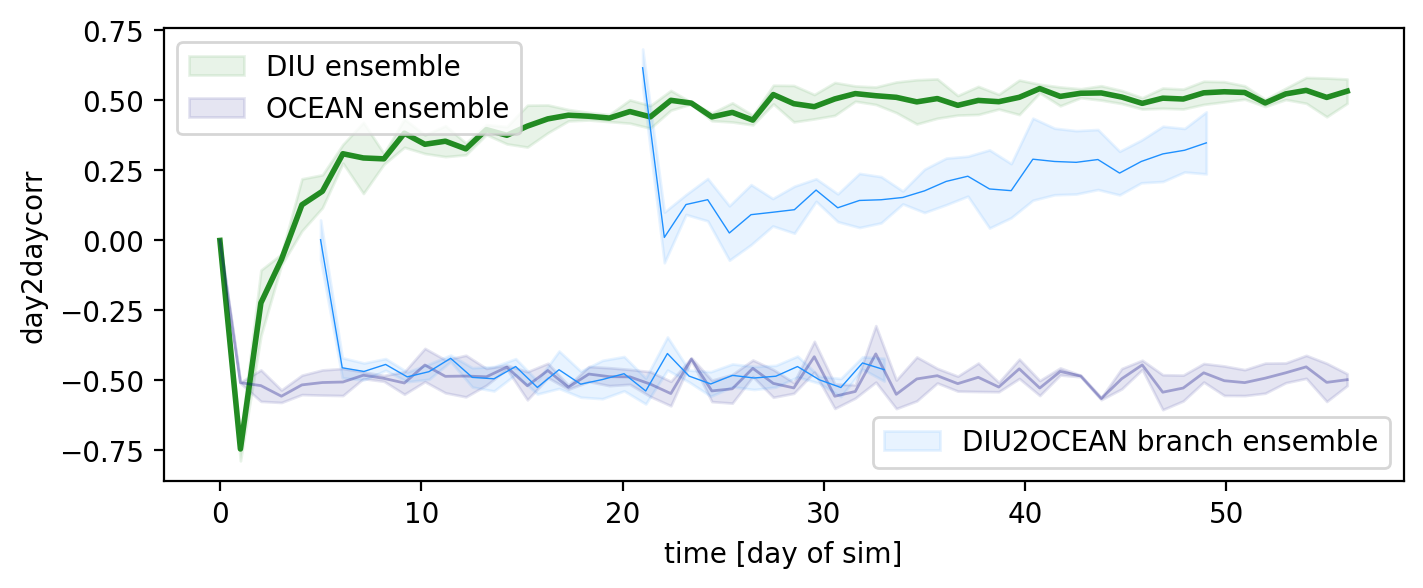

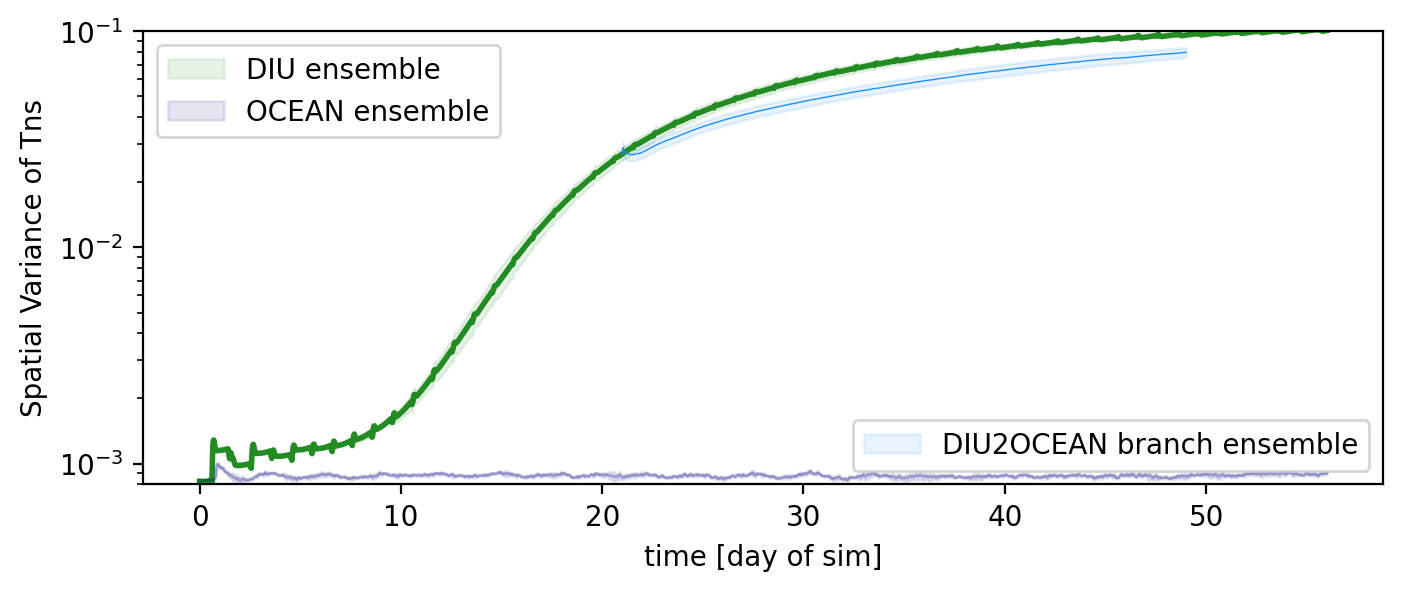

In [545]:
daybranch1=5
daybranch2=21

diu = np.nanmean(corr_DIU_ALL, axis=0)
diu_std = np.nanstd(corr_DIU_ALL, axis=0)
ocean = np.nanmean(corr_OCEAN_ALL, axis=0)
ocean_std = np.nanstd(corr_OCEAN_ALL, axis=0)
branch1 = np.nanmean(corr_OCEANBRANCH1_ALL,axis=0)
branch1_std = np.nanstd(corr_OCEANBRANCH1_ALL,axis=0)
branch2 = np.nanmean(corr_OCEANBRANCH2_ALL,axis=0)
branch2_std = np.nanstd(corr_OCEANBRANCH2_ALL,axis=0)


diu_var = np.nanmean(var_DIU_ALL, axis=0)
diu_var_std = np.nanstd(var_DIU_ALL, axis=0)
ocean_var = np.nanmean(var_OCEAN_ALL, axis=0)
ocean_var_std = np.nanstd(var_OCEAN_ALL, axis=0)
branch1_var = np.nanmean(var_OCEANBRANCH1_ALL,axis=0)
branch1_var_std = np.nanstd(var_OCEANBRANCH1_ALL,axis=0)
branch2_var = np.nanmean(var_OCEANBRANCH2_ALL,axis=0)
branch2_var_std = np.nanstd(var_OCEANBRANCH2_ALL,axis=0)



plot_branches_all_spread(diu, diu_std, ocean, ocean_std, branch1, branch1_std, branch2, branch2_std, 
                         'day2daycorr', spread='yes',daybranch1=daybranch1, daybranch2=daybranch2)

plot_branches_all_spread(diu_var[::], diu_var_std[::], ocean_var[::], ocean_var_std[::], np.zeros(2), np.zeros(2), branch2_var[::], branch2_var_std[::], 
                         'Spatial Variance of Tns', spread='yes', daybranch1=daybranch1, daybranch2=daybranch2, log='yes')

#plot_branches_all_spread(np.var(Tns,axis=(0,1)), , ocean_var[::-1], ocean_var_std[::-1], branch1_var[::-1], branch1_var_std[::-1], branch2_var[::-1], branch2_var_std[::-1], 
 #                        'Spatial Variance of Tns', spread='yes', daybranch1=daybranch1, daybranch2=daybranch2)

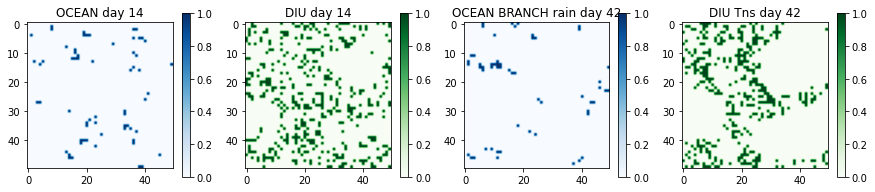

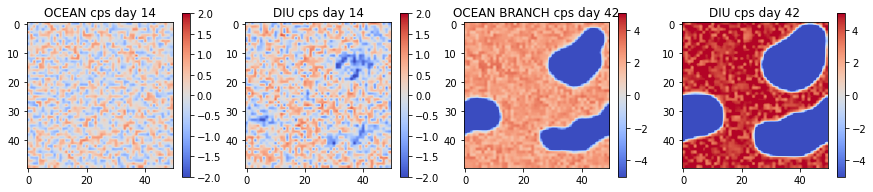

In [543]:
fig = plt.figure(figsize=(15,3))
vmin=0.5
vmax=0.55

ax1 = plt.subplot(141)
ax1.set_title('OCEAN day 14')
ax2 = plt.subplot(142)
ax2.set_title('DIU day 14')
ax3 = plt.subplot(143)
ax3.set_title('OCEAN BRANCH rain day 42')
ax4 = plt.subplot(144)
ax4.set_title('DIU Tns day 42')
#im1 = ax1.imshow(np.mean(x_ocean[14*48:15*48], axis=0), cmap='Blues')
im1 = ax1.imshow(x_ocean[7*48+30], cmap='Blues')
#im2 = ax2.imshow(np.mean(x[14*48:15*48], axis=0), cmap='Greens')
im2 = ax2.imshow(x[7*48+28], cmap='Greens')
#im3 = ax3.imshow(np.mean(x_oceanBRANCH2[7*48:8*48], axis=0),cmap='Blues')
im3 = ax3.imshow(x_oceanBRANCH2[7*48+30],cmap='Blues')
im4 = ax4.imshow(x[42*48+30], cmap='Greens')
fig.colorbar(im1, ax=ax1, orientation='vertical')
fig.colorbar(im2, ax=ax2, orientation='vertical')
fig.colorbar(im3, ax=ax3, orientation='vertical')
fig.colorbar(im4, ax=ax4, orientation='vertical')
plt.show()



cps = Tns[:] - np.mean(Tns,axis=(1,2))[:,None,None]
cps_ocean = Tns_ocean[:] - np.mean(Tns_ocean,axis=(1,2))[:,None,None]
cps_oceanBRANCH2 = Tns_oceanBRANCH2[:] - np.mean(Tns_oceanBRANCH2,axis=(1,2))[:,None,None]

fig = plt.figure(figsize=(15,3))
vmin=0.5
vmax=0.55

ax1 = plt.subplot(141)
ax1.set_title('OCEAN cps day 14')
ax2 = plt.subplot(142)
ax2.set_title('DIU cps day 14')
ax3 = plt.subplot(143)
ax3.set_title('OCEAN BRANCH cps day 42')
ax4 = plt.subplot(144)
ax4.set_title('DIU cps day 42')
#im1 = ax1.imshow((np.mean(cps_ocean[14*48:15*48], axis=0)), cmap='coolwarm')
#im2 = ax2.imshow((np.mean(cps[14*48:15*48], axis=0)), cmap='coolwarm')
#im3 = ax3.imshow((np.mean(cps_oceanBRANCH2[7*48:8*48], axis=0)),cmap='coolwarm')
#im4 = ax4.imshow((np.mean(cps[42*48:43*48], axis=0)), cmap='coolwarm')
im1 = ax1.imshow(20*cps_ocean[7*48+30], cmap='coolwarm', vmin=-2, vmax=2)
im2 = ax2.imshow(20*cps[7*48+30], cmap='coolwarm',vmin=-2, vmax=2)
im3 = ax3.imshow(20*cps_oceanBRANCH2[7*48+30],cmap='coolwarm',vmin=-5, vmax=5)
im4 = ax4.imshow(20*cps[42*48+30], cmap='coolwarm',vmin=-5, vmax=5)
fig.colorbar(im1, ax=ax1, orientation='vertical')
fig.colorbar(im2, ax=ax2, orientation='vertical')
fig.colorbar(im3, ax=ax3, orientation='vertical')
fig.colorbar(im4, ax=ax4, orientation='vertical')
plt.show()

In [198]:
np.shape(np.ones(np.shape(Tns)))


(2688, 50, 50)